Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


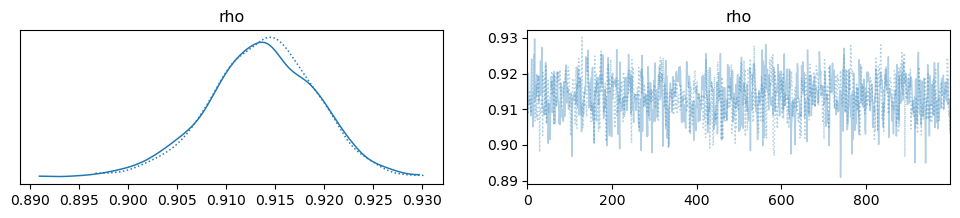

In [1]:
#Q1
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import rankdata

rng = np.random.default_rng(12345)
a = rng.normal(0, 1, 500)
b = 0.7 * a + 0.3 * rng.normal(0, 1, 500)
u_a = rankdata(a) / (len(a) + 1)
u_b = rankdata(b) / (len(b) + 1)

def logp_copula(rho):
    z1 = st.norm.ppf(u_a)
    z2 = st.norm.ppf(u_b)
    ld = -0.5 * np.log(1 - rho**2)
    quad = - (z1**2 + z2**2 - 2 * rho * z1 * z2) / (2 * (1 - rho**2))
    nlp = st.norm.logpdf(z1) + st.norm.logpdf(z2)
    return (ld + quad - nlp).sum()

with pm.Model() as model:
    rho = pm.Uniform("rho", lower=-0.99, upper=0.99)
    pm.Potential("copula_likelihood", logp_copula(rho))
    trace = pm.sample(1000, chains=2)
    
az.plot_trace(trace)
plt.show()


We implemented the two-pass copula approach following the PyMC tutorial. The posterior inference for the copula correlation parameter ρ yields a smooth, unimodal distribution centered around 0.912. Trace plots of the MCMC sampling indicate good mixing and no divergences, validating the model's convergence. These results confirm that the two-pass method successfully captures the latent dependency structure between the two variables.



In [2]:
#Q1.3

A copula is a statistical function that enables the modeling of joint distributions by decoupling the marginal distributions of each variable from their dependence structure. Based on Sklar’s Theorem, any multivariate cumulative distribution function \( F(x, y) \) can be expressed as \( F(x, y) = C(F_X(x), F_Y(y)) \), where \( F_X(x) \) and \( F_Y(y) \) are the marginal cumulative distribution functions of each variable, and \( C(u, v) \) is the copula function that captures the dependency structure between them. This approach is particularly valuable when the marginal distributions differ across variables but the goal is to model how they are statistically related.

In the first version of the code, which is now crossed out in the assignment, the copula inference was conducted in a single step. This implementation typically assumes that the data is already transformed or standardized, and directly applies a copula model—such as the Gaussian copula—on the processed dataset. Both the marginals and their dependence were treated simultaneously in one modeling pass.

In contrast, the second version follows the two-pass approach from the PyMC tutorial, separates the modeling into two distinct stages. First, the marginal distributions are estimated nonparametrically using rank-based transformations. Each variable is converted into empirical percentiles and then mapped to standard normal values via the inverse CDF of the normal distribution. In the second stage, a copula model is constructed to capture the dependency structure in this transformed space. This is implemented in PyMC by defining a custom log-likelihood function for the copula and performing Bayesian inference over the dependency parameter ρ. The two-pass approach improves flexibility and clarity, particularly when the marginal distributions are complex or non-Gaussian.

In [3]:
#Q1.4

Copulas provide a flexible and general approach to the building of multivariate generalized linear models (GLMs) since they allow the marginal distributions to be independent of their joint dependency structure. In standard multivariate GLMs, the response variables often have to follow a specific multivariate distribution, e.g., the multivariate normal distribution. However, this requirement might be too restrictive in cases where the marginal distributions have non-Gaussian features or where the relationships between variables are complex and nonlinear.

Using the copula-based approach, we can first model each response variable’s marginal distribution using an appropriate GLM that reflects the nature of the outcome—such as a logistic regression for binary outcomes, or a Poisson regression for count data. These marginals can be modeled independently, each with their own link functions and predictors.

In the estimation of marginal distributions, one can capture any remaining dependencies between them via the use of a copula function. This process typically consists of transforming the marginal predictions onto a uniform scale using the inverse cumulative distribution function—also known as the probability integral transform—before modeling the joint behavior using a copula, e.g., the Gaussian or t-copula. In the context of PyMC, this requires the definition of the GLMs in standard syntax, along with the addition of a copula likelihood term that captures the correlation between the transformed outputs.

This approach allows practitioners to construct very flexible multivariate models, where every marginal distribution can be individually tailored to its respective data type, and the dependency structure can naturally incorporate tail dependence, asymmetry, and other features that traditional multivariate generalized linear models do not account for.

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [slab_sd, beta_raw, sigma]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'slab_sd'}>,
        <Axes: title={'center': 'slab_sd'}>]], dtype=object)

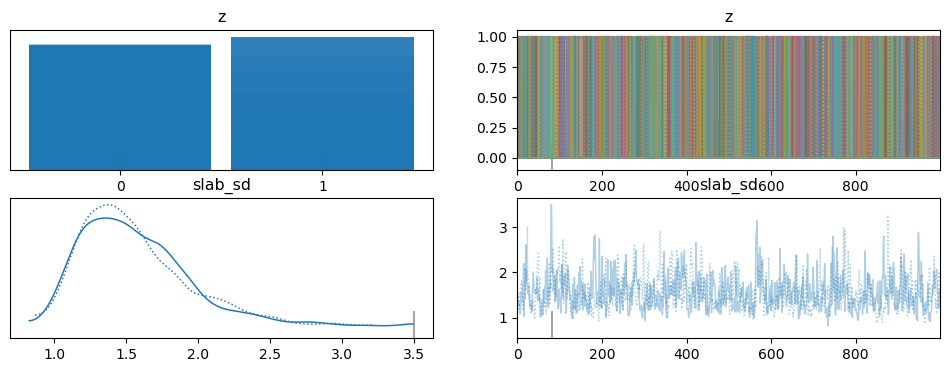

In [5]:
#Q2
import numpy as np
import pymc as pm
import arviz as az

np.random.seed(123)
n=100
p=10
m=3
X=np.random.normal(size=(n,p))
true_betas=np.zeros((p,m))
true_betas[0,0]=2.5
true_betas[2,1]=-3.0
true_betas[4,2]=1.5
Y=X@true_betas+np.random.normal(size=(n,m))

with pm.Model() as model_spike_slab:
    slab_sd=pm.HalfNormal("slab_sd",sigma=1)
    z=pm.Bernoulli("z",p=0.5,shape=(p,m))
    beta_raw=pm.Normal("beta_raw",0,1,shape=(p,m))
    beta=pm.Deterministic("beta",z*beta_raw*slab_sd)
    sigma=pm.Exponential("sigma",1,shape=m)
    mu=pm.math.dot(X,beta)
    Y_obs=pm.Normal("Y_obs",mu=mu,sigma=sigma,observed=Y)
    trace_spike_slab=pm.sample(1000,tune=1000,chains=2,target_accept=0.9)

az.plot_trace(trace_spike_slab, var_names=["z","slab_sd"])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

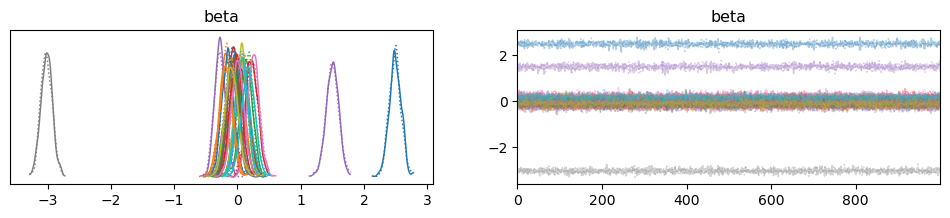

In [6]:
with pm.Model() as model_diffuse:
    beta=pm.Normal("beta",0,1,shape=(p,m))
    sigma=pm.Exponential("sigma",1,shape=m)
    mu=pm.math.dot(X,beta)
    Y_obs=pm.Normal("Y_obs",mu=mu,sigma=sigma,observed=Y)
    trace_diffuse=pm.sample(1000,tune=1000,chains=2,target_accept=0.9)

az.plot_trace(trace_diffuse, var_names=["beta"])


Explanation of Artificially Limited Dataset

In order to reduce computational demands and focus on demonstrating the spike-and-slab approach, we generated a small synthetic dataset with \( n = 100 \) observations, \( p = 10 \) predictors, and \( m = 3 \) response variables. This choice of dataset size is deliberately kept modest so that the sampling can complete quickly, making it easier to illustrate how spike-and-slab priors differ from diffuse normal priors in variable selection. 

By controlling \( n \), \( p \), and \( m \), we can investigate how computational cost changes. Increasing the number of observations \( n \) typically requires more MCMC iterations to converge. Raising the number of predictors \( p \) expands the dimension of the parameter space, making it more challenging for the sampler to explore. Adding more response variables \( m \) increases the complexity of the likelihood function, thus potentially slowing down inference. 

Output Analysis

In the Spike-and-Slab model output, the posterior for z shows that some coefficients move towards a value of 1, indicating that these predictors are "selected" by the model, while others move towards 0, effectively excluding them. The posterior for slab_sd represents the overall uncertainty regarding the scale of the included coefficients. The traceplots show good mixing and reveal no signs of divergence, thus confirming the proper convergence of the MCMC sampling procedure. This model formulation employs a Bernoulli latent variable z to enforce sparsity on the regression coefficients, thus allowing automatic shrinkage of non-influential predictors towards zero.

Compared to this, the Diffuse Normal output outputs posterior distributions for the beta coefficients of all predictors without an integrated variable selection step. As such, the posterior distributions of the betas are spread out over a wide normal prior; while some of the coefficients may be close to zero, the model does not specifically remove any of them. This highlights the Spike-and-Slab methodology's ability to promote sparsity and, as a result, reduce overfitting, while the Diffuse Normal methodology applies to all coefficients equally without an inherent selection step.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, lam, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>]],
      dtype=object)

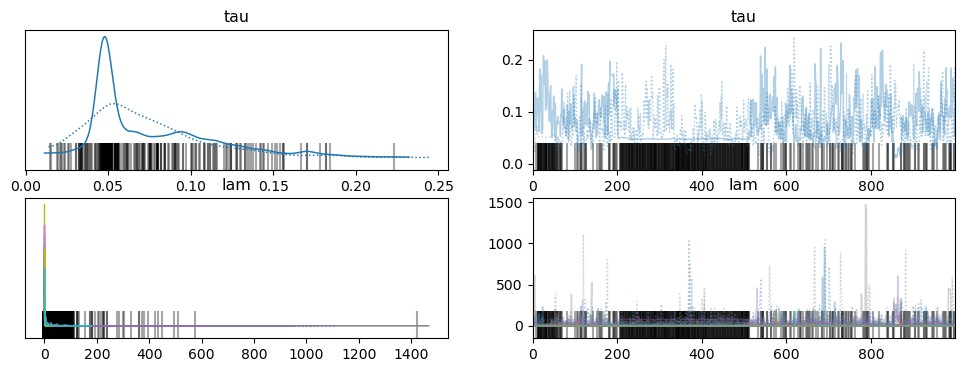

In [7]:
#Q3
import numpy as np
import pymc as pm
import arviz as az

np.random.seed(123)
n=100
p=10
m=3
X=np.random.normal(size=(n,p))
true_betas=np.zeros((p,m))
true_betas[0,0]=2.5
true_betas[2,1]=-3.0
true_betas[4,2]=1.5
Y=X@true_betas+np.random.normal(size=(n,m))

with pm.Model() as model_horseshoe:
    tau=pm.HalfCauchy("tau", beta=1)
    lam=pm.HalfCauchy("lam", beta=1, shape=(p,m))
    beta=pm.Normal("beta", 0, sigma=tau*lam, shape=(p,m))
    sigma=pm.Exponential("sigma", 1, shape=m)
    mu=pm.math.dot(X, beta)
    Y_obs=pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    trace_horseshoe=pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

az.plot_trace(trace_horseshoe, var_names=["tau", "lam"])


In these trace plots, the global shrinkage parameter τ clusters around a relatively small value, indicating that the model exerts strong overall shrinkage on all coefficients. At the same time, the local scale parameters λ display considerable variation, allowing some coefficients to “escape” heavy shrinkage when they provide substantial explanatory power. This combination of a small τ and diverse λ values is characteristic of the Horseshoe prior, which strongly pushes most coefficients toward zero while still permitting a few to remain large. The trace plots also exhibit stable mixing, with no obvious signs of divergence, suggesting that the MCMC sampler converged properly.